In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.transpiler import CouplingMap

from gate_level.spillover_noise_use_case.generic_spillover.generic_spillover_noise import (
    numpy_to_hashable,
)
from generic_spillover_noise import (
    circuit_context,
    noisy_backend,
    SpilloverNoiseAerPass,
)
from rl_qoc import (
    ContextAwareQuantumEnvironment,
    BackendConfig,
    QEnvConfig,
    ExecutionConfig,
    GateTarget,
)

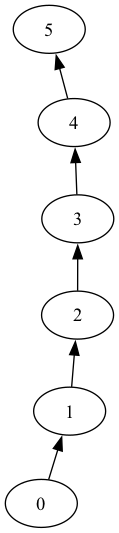

In [2]:
# Define the number of qubits
num_qubits = 6
cm = CouplingMap.from_line(num_qubits, False)
cm.draw()

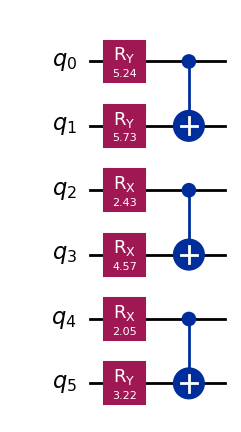

In [3]:
# Define parameters for U(phi) gates
# phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
rotation_angles = np.random.uniform(0, 2 * np.pi, size=num_qubits)
# gate_types = ['RY', 'RY', 'RX', 'RX', 'RX', 'RY']
sq_gates = {0: "ry", 1: "ry", 2: "rx", 3: "rx", 4: "rx", 5: "ry"}  # {qubit: gate_type}
# Create the quantum circuit
qc = circuit_context(
    num_qubits, list(sq_gates.values()), rotation_angles, coupling_map=cm
)

# Display the circuit structure
qc.draw("mpl")

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[0, 3] = 0.025  # γ_0->3
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

gamma_matrix

array([[0.   , 0.025, 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.025, 0.   ]])

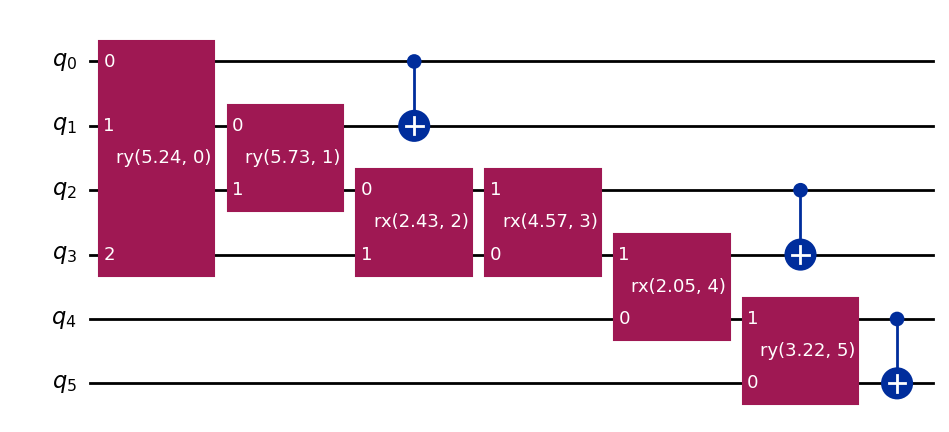

In [5]:
from qiskit.transpiler import PassManager

pm = PassManager(
    [SpilloverNoiseAerPass(spillover_rate_matrix=numpy_to_hashable(gamma_matrix))]
)
noisy_qc = pm.run(qc)
noisy_qc.draw("mpl")

In [6]:
# Create the noisy backend tailored for spillover noise
backend = noisy_backend(qc, gamma_matrix, coupling_map=cm)
backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['ry(5.24, 0)', 'rx(4.57, 3)', 'ry(3.22, 5)', 'ry(5.73, 1)', 'rx(2.43, 2)', 'rx(2.05, 4)']>)

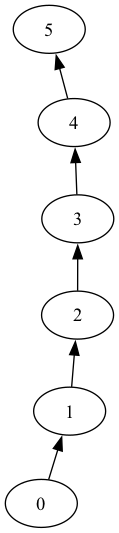

In [7]:
backend.coupling_map.draw()

In [8]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '0b1614427194408197bbbe6b666a1b01',
   'operations': ['ry(5.24, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1, 2],
      'params': [array([[ 0.99571205+0.j,  0.        +0.j, -0.06534193+0.j,
               -0.        +0.j, -0.06534193+0.j, -0.        +0.j,
                0.00428795-0.j,  0.        -0.j],
              [ 0.        +0.j,  0.99571205+0.j, -0.        +0.j,
               -0.06534193+0.j, -0.        +0.j, -0.06534193+0.j,
                0.        -0.j,  0.00428795-0.j],
              [ 0.06534193+0.j,  0.        +0.j,  0.99571205+0.j,
                0.        +0.j, -0.00428795+0.j, -0.        +0.j,
               -0.06534193+0.j, -0.        +0.j],
              [ 0.        +0.j,  0.06534193+0.j,  0.        +0.j,
                0.99571205+0.j, -0.        +0.j, -0.00428795+0.j,
               -0.        +0.j, -0.06534193+0.j],
              [ 0.06534193+0.j,  0.        +0.j, -0.00428795+0.j,
               -0.

In [9]:
from qiskit import QuantumRegister


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{target['gate'].name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [10]:
# Define the environment
from gymnasium.spaces import Box
from qiskit.circuit.library import CXGate

action_space = Box(low=-np.pi, high=np.pi, shape=(7,), dtype=np.float32)
target = {"gate": CXGate(), "physical_qubits": [2, 3]}

backend_config = BackendConfig(
    apply_parametrized_circuit,
    backend=backend,
    pass_manager=pm,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(),
)
env = ContextAwareQuantumEnvironment(q_env_config, circuit_context=qc)

In [11]:
backend.operations

[Instruction(name='s', num_qubits=1, num_clbits=0, params=[]),
 qiskit.quantum_info.operators.channel.quantum_channel.QuantumChannel,
 Instruction(name='u', num_qubits=1, num_clbits=0, params=[Parameter(ϴ), Parameter(φ), Parameter(λ)]),
 qiskit_aer.library.save_instructions.save_expectation_value.SaveExpectationValue,
 qiskit_aer.library.set_instructions.set_stabilizer.SetStabilizer,
 qiskit.circuit.library.data_preparation.initializer.Initialize,
 qiskit_aer.library.save_instructions.save_stabilizer.SaveStabilizer,
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 qiskit_aer.library.save_instructions.save_superop.SaveSuperOp,
 qiskit.circuit.controlflow.switch_case.SwitchCaseOp,
 qiskit_aer.library.save_instructions.save_statevector.SaveStatevectorDict,
 qiskit.quantum_info.operators.channel.superop.SuperOp,
 qiskit_aer.library.save_instructions.save_amplitudes.SaveAmplitudes,
 qiskit_aer.library.set_instructions.set_superop.SetSuperOp,
 qiskit_aer.library.save_instruct

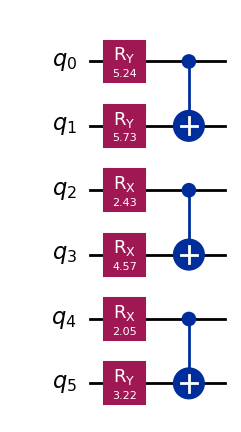

In [12]:
env.circuit_context.draw("mpl")

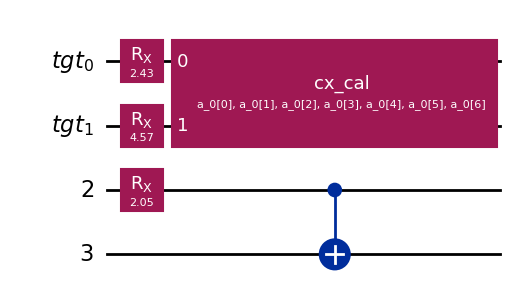

In [13]:
env.circuits[0].draw("mpl")

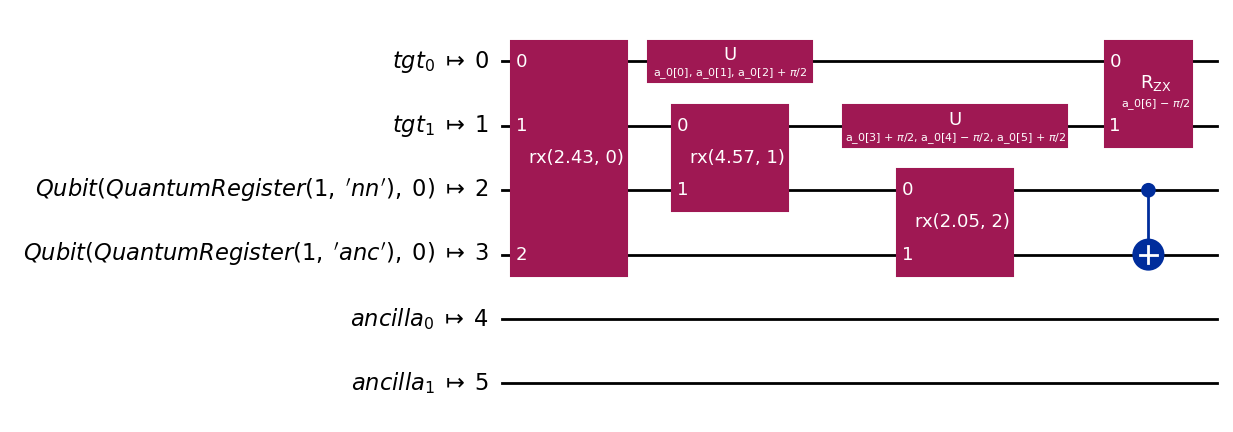

In [14]:
env.backend_info.custom_transpile(env.circuits[0]).draw("mpl")